# **Анализ результатов A/B-тестирования: кумулятивные метрики**

Итак, давайте рассмотрим, как проводится анализ результатов A/B-тестирования (в нашем алгоритме он был обозначен под номером 6) с помощью Python.

![](https://lms.skillfactory.ru/assets/courseware/v1/ba083e24b47b02b96efcd0fa4566fa5e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-eda-5-9.png)

В качестве примера давайте попробуем решить задачу об анализе конверсии на некотором интернет-магазине, который занимается продажей различных товаров. 

***
### **ОПИСАНИЕ ЗАДАЧИ**

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

* Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
* Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.

Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия **«добавить в корзину сопутствующий товар**»).

Для этого пользователи были разделены на две группы. 

Контрольной (группе А) доступен первый вариант рекомендаций.
Тестовой (группе B) доступен второй вариант. 
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

Итак, в результате проведения A/B-тестирования были получены следующие данные:

[данные](https://lms.skillfactory.ru/assets/courseware/v1/f9f05ba6ecb36996a8ec5c6e89cd2a75/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_data.zip)



***
### **ЗНАКОМИМСЯ С ДАННЫМИ**


In [1]:
# импортируем библиотеки, которые нам пригодятся:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('data/ab_data.csv')
display(ab_data.head())
display(ab_data.info())

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


None

In [3]:
# нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода **reset_index()** и переименуем столбец user_id в users_count с помощью метода **rename()**.

In [4]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Примечание. Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).


In [5]:
# Рассчитайте конверсию на каждый день
# Результат занесите в столбец conversion. Чему была равна конверсия (в процентах)
# в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

daily_data['conversion'] = daily_data['converted']/daily_data['users_count']*100
display(daily_data.head())
display(daily_data[(daily_data['timestamp'] == '2017-01-05')&(daily_data['group'] == 'A')]['conversion'].round(2))

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


6    12.32
Name: conversion, dtype: float64

***
### **ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ**


Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму **boxplot** для сравнения параметров распределения ежедневной конверсии по группам. 

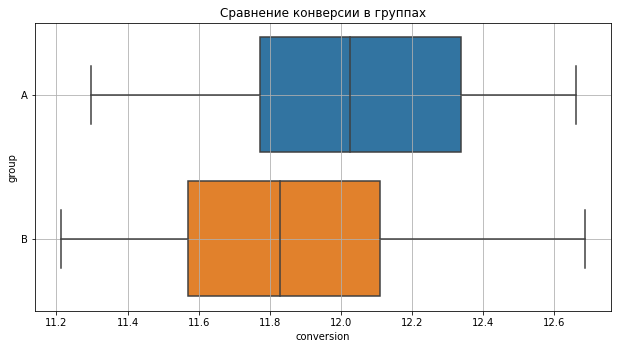

In [6]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

                                                                Вывод
Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

In [7]:
# Давайте вычислим средний и медианный показатель конверсии в контрольной
# и тестовой группе и умножим результат на 100 (получим результат в процентах):
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Возникает вопрос: **а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?**

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут **кумулятивные метрики**.

***
### **КУМУЛЯТИВНЫЕ МЕТРИКИ**

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

    Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Ранее мы говорили, что для принятия решения в A/B-тестировании требуется большой объём данных, что соотносится с законом больших чисел: чем больше данных — тем ближе получаемый результат к математическому ожиданию (истинному среднему). 

Вспомните пример про подбрасывание монетки. Если подбросить монетку 10 раз, то велика вероятность, что один из двух результатов будет значительно превышать второй. Но если подбросить её 1 000 раз, то результаты компенсируют друг друга, и мы увидим, что итог крайне близок к разделению 50/50 (количество выпавших орлов и решек будет практически одинаковым).

Так же и в A/B-тестировании: **с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется проблемой подглядывания**.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

Кумулятивный график конверсии может выглядеть, например, так: 

![](https://lms.skillfactory.ru/assets/courseware/v1/fde294a0331aca21aaa425f878fdfcd3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-eda-5-19.png)

Как видите, в начале данные подвержены сильному колебанию, но со временем они выравниваются.

Примечание. **Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую**.

Согласно центральной предельной теореме и закону больших чисел, **с увеличением объёма данных метрика стабилизируется** и будет стремиться к реальному среднему.



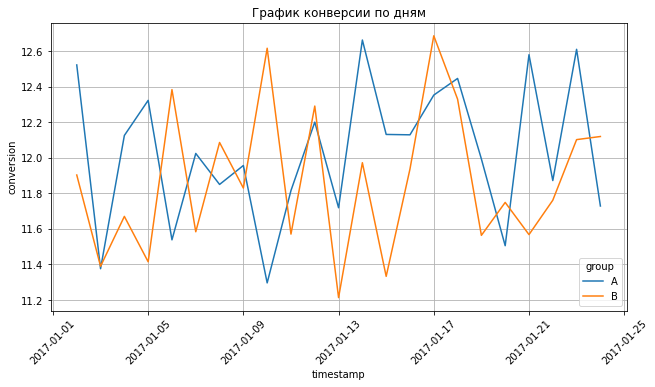

In [8]:
# Посмотрим, как вообще изменялись показатели
# ежедневной конверсии в каждой группе во времени.
# Для этого построим линейные графики для каждой группы:
# по оси абсцисс отложим дату, а по оси ординат — показатель конверсии

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод [**cumsum()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

In [9]:
# Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count,
# в который запишем результат работы метода cumsum() по столбцу users_count:

# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\4049114135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Обратите внимание, что в столбце с кумулятивной суммой за 2017-01-02 указано 9 435 пользователей. Сложите данные за 2017-01-02 и 2017-02-03 из столбца users_count — получите те же 9 435. Аналогично и для других дней. 

То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

Кумулятивную сумму можно записать в виде рекурсивной формулы:

                                                    St = St-1 + x1

x1 — значение показателя в день t;
St — значение суммы в день t.

In [10]:
#  рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной
# суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий

# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


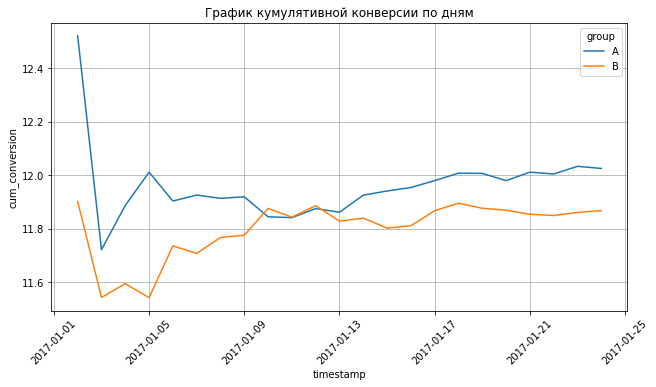

In [11]:
# А теперь построим графики кумулятивной конверсии по дням в каждой группе:

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-11-01 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

***
### **ЗАДАЧИ**


In [12]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')
display(sample_a.head())
display(sample_b.head())

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


* date — дата наблюдения;
* cid — идентификатор посетителя;
* transactions — количество совершённых целевых действий (транзакций);
* revenue — сумма покупки;
* group — группа (тестовая — А, контрольная — B).

In [13]:
samples = pd.concat([sample_a,sample_b]).reset_index()
samples.drop(samples.columns[[0]], axis=1, inplace=True)
# нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime
samples['date'] = pd.to_datetime(samples['date'], format='%Y-%m-%d')
display(samples.tail())

,date,cid,transactions,revenue,group
122949,2020-11-23,9.965675e+08,0,0,B
122950,2020-11-23,9.970803e+07,0,0,B
122951,2020-11-23,9.984814e+08,0,0,B
122952,2020-11-23,9.991118e+08,0,0,B
122953,2020-11-23,9.994657e+08,0,0,B


In [14]:
# группируем
samples_grouped = samples.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
samples_grouped.head(10)

,date,group,users_count,transactions,revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051
5,2020-11-08,B,3291,24,3044842
6,2020-11-09,A,3234,18,708830
7,2020-11-09,B,3062,25,1285836
8,2020-11-10,A,3022,29,826984
9,2020-11-10,B,3072,30,2414726


In [15]:
# Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?
# Количество посетителей сайта:
print('Kоличество посетителей сайта: ',samples_grouped[(samples_grouped['date']=='2020-11-08')&(samples_grouped['group']=='A')]['users_count'].sum(),'\n')
# Суммарное число транзакций:
print('Суммарное число транзакций: ',samples_grouped[(samples_grouped['date']=='2020-11-08')&(samples_grouped['group']=='A')]['transactions'].sum(),'\n')
# Общая сумма покупок:
print('Общая сумма покупок: ',samples_grouped[(samples_grouped['date']=='2020-11-08')&(samples_grouped['group']=='A')]['revenue'].sum(),'\n')


Kоличество посетителей сайта:  3354 

Суммарное число транзакций:  25 

Общая сумма покупок:  846051 



Добавьте в каждую из таблиц кумулятивные метрики:

* кумулятивное количество посетителей сайта;
* кумулятивное суммарное число транзакций;
* кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

In [16]:
# Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count,
# в который запишем результат работы метода cumsum() по столбцу users_count:

# выделяем данные группы А
samples_grouped_a = samples_grouped[samples_grouped['group'] == 'A']
# считаем кумулятивное количество посетителей
samples_grouped_a.loc[:, 'cum_users_count'] = samples_grouped_a['users_count'].cumsum()
samples_grouped_a.loc[:, 'cum_transactions'] = samples_grouped_a['transactions'].cumsum()
samples_grouped_a.loc[:, 'cum_revenue'] = samples_grouped_a['revenue'].cumsum()
samples_grouped_a.loc[:, 'cum_revenue'] = samples_grouped_a['revenue'].cumsum()
samples_grouped_a['cum_conversion'] = samples_grouped_a['cum_transactions']/samples_grouped_a['cum_users_count']*100
samples_grouped_a['cum_check'] = samples_grouped_a['cum_revenue']/samples_grouped_a['cum_transactions']
# выводим время, количество посетителей и кумулятивное количество посетителей
display(samples_grouped_a.head())

# выделяем данные группы B
samples_grouped_b = samples_grouped[samples_grouped['group'] == 'B']
# считаем кумулятивное количество посетителей
samples_grouped_b.loc[:, 'cum_users_count'] = samples_grouped_b['users_count'].cumsum()
samples_grouped_b.loc[:, 'cum_transactions'] = samples_grouped_b['transactions'].cumsum()
samples_grouped_b.loc[:, 'cum_revenue'] = samples_grouped_b['revenue'].cumsum()
samples_grouped_b.loc[:, 'cum_revenue'] = samples_grouped_b['revenue'].cumsum()
samples_grouped_b['cum_conversion'] = samples_grouped_b['cum_transactions']/samples_grouped_b['cum_users_count']*100
samples_grouped_b['cum_check'] = samples_grouped_b['cum_revenue']/samples_grouped_b['cum_transactions']
# выводим время, количество посетителей и кумулятивное количество посетителей
display(samples_grouped_b.head())


C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\1753215330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_grouped_a.loc[:, 'cum_users_count'] = samples_grouped_a['users_count'].cumsum()
C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\1753215330.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_grouped_a.loc[:, 'cum_transactions'] = samples_grouped_a['transactions'].cumsum()
C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\1753215330.py:9: SettingWithCopyWarning: 
A value is tryin

,date,group,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_check
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000
6,2020-11-09,A,3234,18,708830,11868,82,4854046,0.690934,59195.682927
8,2020-11-10,A,3022,29,826984,14890,111,5681030,0.745467,51180.450450


C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\1753215330.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_grouped_b.loc[:, 'cum_users_count'] = samples_grouped_b['users_count'].cumsum()
C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\1753215330.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_grouped_b.loc[:, 'cum_transactions'] = samples_grouped_b['transactions'].cumsum()
C:\Users\Роман\AppData\Local\Temp\ipykernel_76368\1753215330.py:21: SettingWithCopyWarning: 
A value is tr

,date,group,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_check
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737
5,2020-11-08,B,3291,24,3044842,8594,62,4596986,0.721434,74144.935484
7,2020-11-09,B,3062,25,1285836,11656,87,5882822,0.746397,67618.643678
9,2020-11-10,B,3072,30,2414726,14728,117,8297548,0.794405,70919.213675


In [17]:
# Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста?
# Ответ округлите до сотых, знаки процентов не вводите.

a_cum_conv_mean = samples_grouped_a['cum_conversion'].mean().round(2)
b_cum_conv_mean = samples_grouped_b['cum_conversion'].mean().round(2)

print(a_cum_conv_mean, '\n', b_cum_conv_mean)

0.71 
 0.76


In [18]:
samples = pd.concat([samples_grouped_a,samples_grouped_b]).reset_index()
samples.drop(samples.columns[[0]], axis=1, inplace=True)

In [25]:
# записываем на следующий юнит
samples.to_csv('data/samples.csv',index=False)

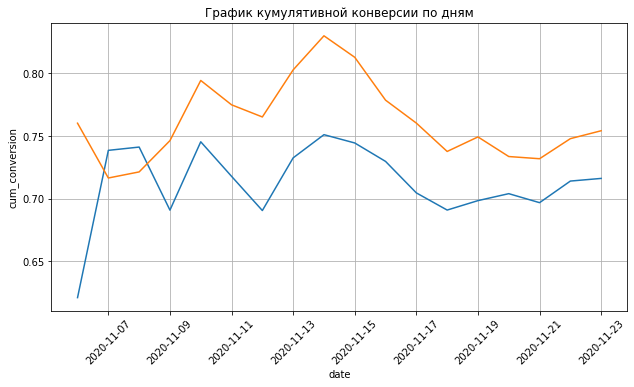

In [19]:
# Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=samples_grouped_a, ax=ax)
sns.lineplot(x='date', y='cum_conversion', data=samples_grouped_b, ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

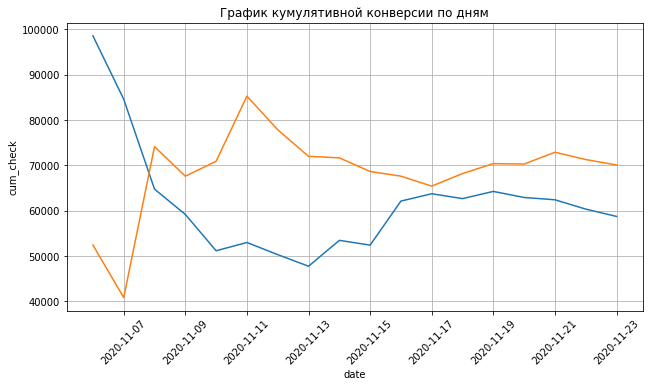

In [20]:
# Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_check', data=samples_grouped_a, ax=ax)
sns.lineplot(x='date', y='cum_check', data=samples_grouped_b, ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);